In [141]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 10.0)

In [3]:
def parse_time(raw_time):
    '''Parse the raw time strings into timedeltas for doing arithmetic on the times'''
    if raw_time == '' or None:
        return None
    else:
        try:
            dt = datetime.datetime.strptime(raw_time, '%M:%S.%f')
            timedelta = datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
            return timedelta
        except:
            dt = datetime.datetime.strptime(raw_time, '%S.%f')
            timedelta = datetime.timedelta(seconds=dt.second, microseconds=dt.microsecond)
            return timedelta


def timedeltaToString(rawTd):
    '''Convert timedelta to a MM:SS.000 formatted string'''
    try:
        dt = str(rawTd)[-12:-3]
        return dt
    except:
        return None

In [95]:
def processResults(df):
    '''Calculate split times, time gaps and rankings for each rider'''
    #Apply the time parser to the raw times
    for i in range(1,6):
        df['split' + str(i)] = df['split' + str(i)].apply(parse_time)

    #Calculate the total sector times for each split
    df['sector1'] = df['split1']
    df['sector2'] = df['split2'] - df['split1']
    df['sector3'] = df['split3'] - df['split2']
    df['sector4'] = df['split4'] - df['split3']
    df['sector5'] = df['split5'] - df['split4']

    #Calculate the time gaps and rankings for everything
    cols = ['sector1', 'sector2', 'sector3','sector4', 'sector5', 'split1', 'split2', 'split3','split4', 'split5']

    for col in cols:
        df[col + 'Gap'] = df[col].apply(lambda x: (x - df[col].min())/np.timedelta64(1,'s'))
        df[col + 'Rank'] = df[col].rank().astype(int)
        df[col] = df[col].apply(timedeltaToString)
        df[col + 'Rank']

    return df

In [96]:
df = pd.read_excel('2016_01_Lourdes_Men_munged.xlsx')
df.reset_index(inplace=True)
cols = ['Index',
        'Rank', 
        'P', 
        'Bib', 
        'UCI Code', 
        'Name', 
        'speed', 
        'split1', 
        'Pos 1 & 2', 
        'split3',
        'Pos 3 & 4',
        'split5',
        'Gap',
        'Pts']
df.columns = cols
df['split2'] = df['split1'].shift(-2)
df['split4'] = df['split3'].shift(-2)
df['Team'] = df['Name'].shift(-2)
df['split5'] = df['split5'].shift(-1)
df['speed'] = df['speed'].shift(-1)
df.head(10)

df2 = df.iloc[::3, :][['Rank','Name','Team','split1', 'split2','split3','split4','split5']]
processResults(df2)
df2.to_csv('Lourdes_Men.csv')
df2.head()

,Rank,Name,Team,split1,split2,split3,split4,split5,sector1,sector2,...,split1Gap,split1Rank,split2Gap,split2Rank,split3Gap,split3Rank,split4Gap,split4Rank,split5Gap,split5Rank
0,1.0,GWIN Aaron,THE YT MOB,01:07.827,01:50.639,02:10.466,02:39.156,03:09.131,01:07.827,00:42.812,...,1.074,3,1.935,2,1.802,2,2.362,2,0.000,1
3,2.0,SMITH Steve,DEVINCI GLOBAL RACING,01:08.280,01:51.775,02:12.166,02:41.249,03:11.602,01:08.280,00:43.495,...,1.527,4,3.071,4,3.502,4,4.455,3,2.471,2
6,3.0,HART Danny,MS MONDRAKER TEAM,01:09.017,01:52.273,02:12.575,02:42.037,03:11.817,01:09.017,00:43.256,...,2.264,7,3.569,5,3.911,5,5.243,4,2.686,3
9,4.0,BROSNAN Troy,SPECIALIZED RACING,01:08.345,01:52.602,02:14.277,02:43.932,03:13.281,01:08.345,00:44.257,...,1.592,5,3.898,6,5.613,10,7.138,8,4.150,4
12,5.0,PIERRON Amaury,LAC BLANC COMMENCAL,01:07.816,01:51.171,02:12.012,02:43.408,03:13.440,01:07.816,00:43.355,...,1.063,2,2.467,3,3.348,3,6.614,6,4.309,5


In [85]:
df_heatmap = df2[df2['split5Rank'] <= 20][['Name', 'split5Rank','sector1Rank', 'sector2Rank', 'sector3Rank', 'sector4Rank', 'sector5Rank']].sort_values('split5Rank')
cols = ['Name', 'Final', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4', 'Sector 5']
df_heatmap.columns = cols
df_heatmap = df_heatmap[['Name', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4', 'Sector 5']]
df_heatmap = df_heatmap.set_index('Name')
df_heatmap.head()

,Sector 1,Sector 2,Sector 3,Sector 4,Sector 5
Name,,,,,
GWIN Aaron,3,4,2,2,5
SMITH Steve,4,10,7,3,10
HART Danny,7,6,5,5,3
BROSNAN Troy,5,17,53,6,1
PIERRON Amaury,2,7,15,26,6


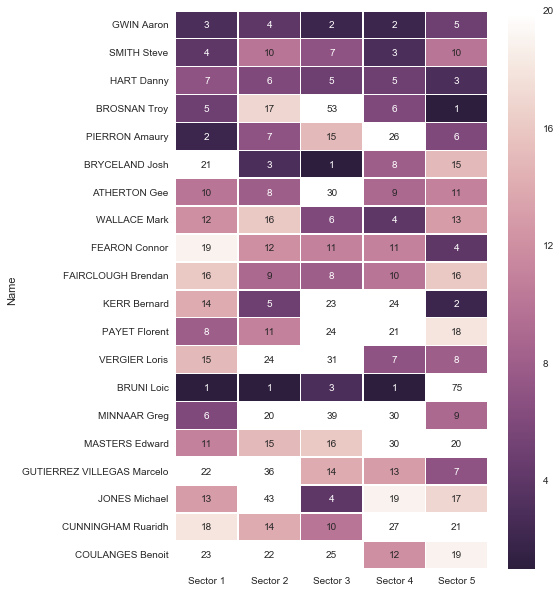

In [142]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.5, vmin=1, vmax=20, cmap=cmap)

In [113]:
df_splittimes = df2[df2['split5Rank'] <= 20][['Name', 'split1Rank','split2Rank', 'split3Rank', 'split4Rank', 'split5Rank']]
df_splittimes = df_splittimes.set_index('Name')
df_splittimes = df_splittimes.T
df_splittimes

Name,GWIN Aaron,SMITH Steve,HART Danny,BROSNAN Troy,PIERRON Amaury,BRYCELAND Josh,ATHERTON Gee,WALLACE Mark,FEARON Connor,FAIRCLOUGH Brendan,KERR Bernard,PAYET Florent,VERGIER Loris,BRUNI Loic,MINNAAR Greg,MASTERS Edward,GUTIERREZ VILLEGAS Marcelo,JONES Michael,CUNNINGHAM Ruaridh,COULANGES Benoit
split1Rank,3,4,7,5,2,21,10,12,19,16,14,8,15,1,6,11,22,13,18,23
split2Rank,2,4,5,6,3,12,8,16,17,14,9,7,20,1,10,13,25,21,18,23
split3Rank,2,4,5,10,3,6,8,13,15,11,9,7,19,1,14,12,24,18,17,23
split4Rank,2,3,4,8,6,5,9,7,12,10,13,11,15,1,17,16,21,19,18,20
split5Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20


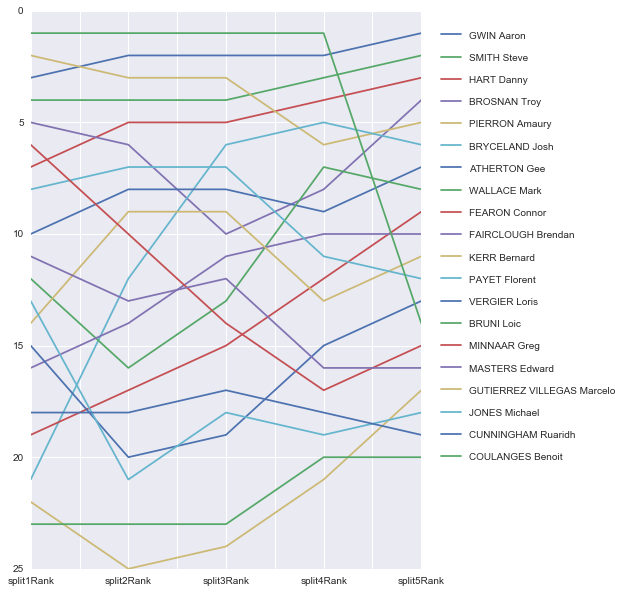

In [143]:
sns.set_style("darkgrid")
df_splittimes.plot()
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1, 1), labelspacing=1.32, borderpad=2, loc=2, borderaxespad=0.)

In [102]:
df2[['sector1','sector2','sector3','sector4','sector5', 'split5']][:1].T


,0
sector1,01:07.827
sector2,00:42.812
sector3,00:19.827
sector4,00:28.690
sector5,00:29.975
split5,03:09.131


In [103]:
crashes = sns.load_dataset("car_crashes")
crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


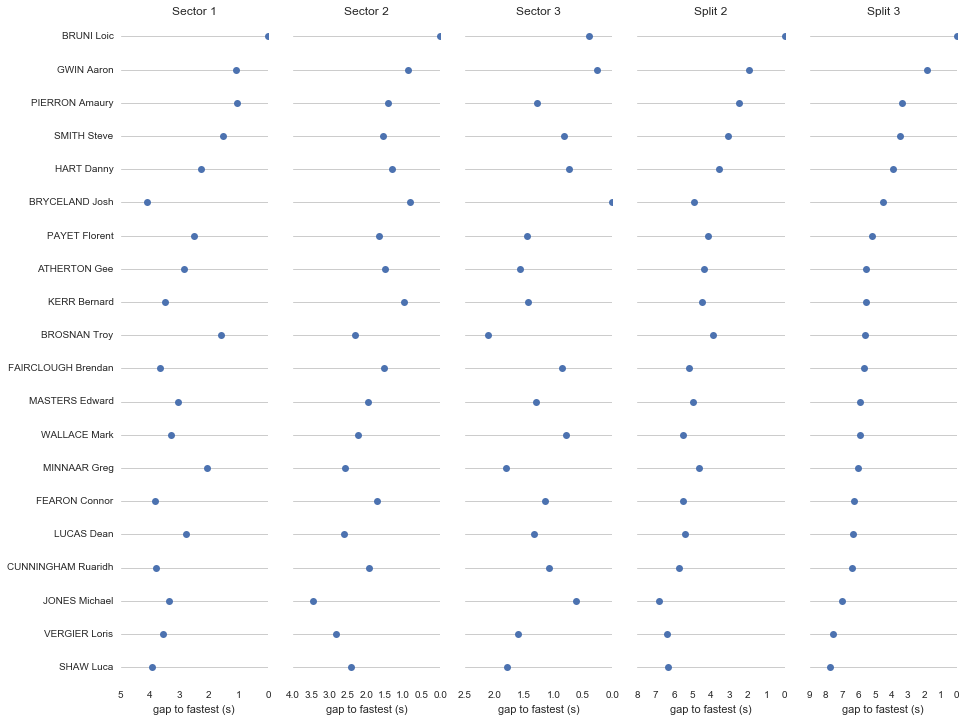

In [157]:
df_split1to3 = df2[['Name','sector1Gap','sector2Gap','sector3Gap','split2Gap','split3Gap']].sort_values("split3Gap", ascending=True)
df_split1to3 = df_split1to3[:20]

sns.set_style("whitegrid")
g = sns.PairGrid(df_split1to3.sort_values("split3Gap", ascending=True),
                 x_vars=df_split1to3.columns[1:6], y_vars=["Name"],
                 size=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=7, orient="h",
    edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0), xlabel="gap to fastest (s)", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Sector 1", "Sector 2",
          "Sector 3", "Split 2", "Split 3"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.invert_xaxis()

sns.despine(left=True, bottom=True)

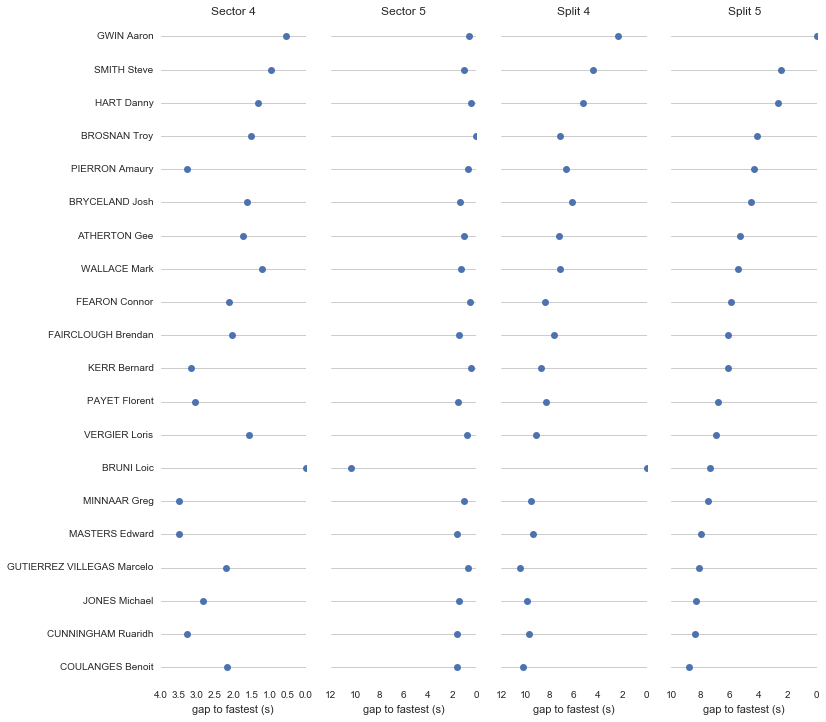

In [156]:
df_split4to5 = df2[['Name','sector4Gap','sector5Gap','split4Gap','split5Gap']].sort_values("split5Gap", ascending=True)
df_split4to5 = df_split4to5[:20]

sns.set_style("whitegrid")
g = sns.PairGrid(df_split4to5.sort_values("split5Gap", ascending=True),
                 x_vars=df_split4to5.columns[1:5], y_vars=["Name"],
                 size=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=7, orient="h",
    edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0), xlabel="gap to fastest (s)", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Sector 4", "Sector 5",
          "Split 4", "Split 5"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.invert_xaxis()

sns.despine(left=True, bottom=True)

In [139]:
df_dots

,Name,sector1Gap,sector2Gap,sector3Gap,sector4Gap,sector5Gap,split5Gap
0,GWIN Aaron,1.074,0.861,0.262,0.560,0.626,0.000
3,SMITH Steve,1.527,1.544,0.826,0.953,1.004,2.471
6,HART Danny,2.264,1.305,0.737,1.332,0.431,2.686
9,BROSNAN Troy,1.592,2.306,2.110,1.525,0.000,4.150
12,PIERRON Amaury,1.063,1.404,1.276,3.266,0.683,4.309
15,BRYCELAND Josh,4.112,0.820,0.000,1.620,1.336,4.505
18,ATHERTON Gee,2.848,1.508,1.560,1.721,1.030,5.284
21,WALLACE Mark,3.274,2.240,0.785,1.217,1.290,5.423
24,FEARON Connor,3.819,1.717,1.150,2.118,0.496,5.917
27,FAIRCLOUGH Brendan,3.660,1.533,0.847,2.025,1.406,6.088


In [140]:
df_splits = df2[['Name','split1Gap','split2Gap','split3Gap','split4Gap','split5Gap']].sort_values("split5Gap", ascending=True)
df_splits[:20]

,Name,split1Gap,split2Gap,split3Gap,split4Gap,split5Gap
0,GWIN Aaron,1.074,1.935,1.802,2.362,0.000
3,SMITH Steve,1.527,3.071,3.502,4.455,2.471
6,HART Danny,2.264,3.569,3.911,5.243,2.686
9,BROSNAN Troy,1.592,3.898,5.613,7.138,4.150
12,PIERRON Amaury,1.063,2.467,3.348,6.614,4.309
15,BRYCELAND Josh,4.112,4.932,4.537,6.157,4.505
18,ATHERTON Gee,2.848,4.356,5.521,7.242,5.284
21,WALLACE Mark,3.274,5.514,5.904,7.121,5.423
24,FEARON Connor,3.819,5.536,6.291,8.409,5.917
27,FAIRCLOUGH Brendan,3.660,5.193,5.645,7.670,6.088
